#  <center> Feedback Prize - English Language Learning </center> 

Thanks to the great notebook: https://www.kaggle.com/code/lextoumbourou/feedback3-eda-hf-custom-trainer-sift

In [23]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict
from IPython.core.display import display, HTML

from sklearn.feature_extraction.text import CountVectorizer

## Evaluation

Submissions are scored using **`MCRMSE`**, **mean columnwise root mean squared error**:

#### Feedback Prize는 총 6개를 예측한다. 따라서 Score은 RMSE을 통해 예측값 7개를 합친다음 나눠서 계산

<div>
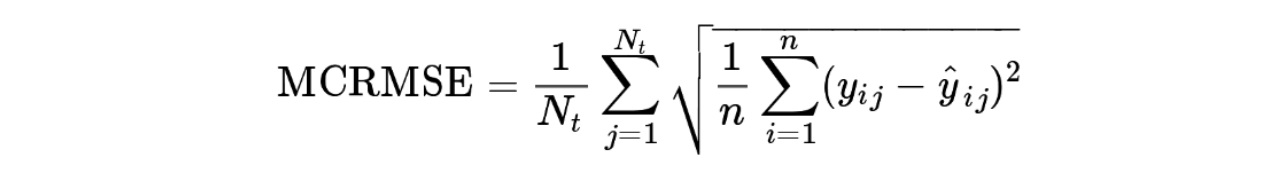
</div>

where $N_{t}$ is the number of columns, and $y$ and $\hat{y}$ are the actual and predicted values, respectively.

### MCRMSE를 정의

In [45]:
def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)

##  Import Data

In [46]:
df_train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
df_test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
submission = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')

In [47]:
df_train.head()
# test_id - 대상 식별 정보
# full_text - Text 원문(단락)
# cohesion - 응집력 / 의미의 구성이 잘되었는가
# syntax - 구문 / 뭄법, 구조 또는 언어 문장 내에 있는 구성요소의 순서가 적절한가
# vocabulary  - 어휘 / 단어의 수준이나 배치가 적절한가 (추측)
# phraseology - 어구 / 관용구나 속담같은 표현
# grammar - 문법 / 문장, 단어의 규칙을 잘지켰는가
# conventions - 관습적인 표현을 잘하였는가?(추측)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [56]:
df_train.full_text[3]

'The best time in life is when you become yourself. I agree that the greatest accomplishment, is when you be yourself in a world that constantly trying to make you something else. Because you make your own choices, you become more happy, and you respect others.\n\nFirst, you make your own choices by being yourself. Becoming yourself means that you should be able to make your own choices and not be shy or afraid of what you\'re doing. Because you\'re defining yourself by doing those things that you want. Some people follow others, therefore, they don\'t make their own choices. People are afraid to make their own choice because they don\'t want to get rejected or be wrong. In this world, most of the teenagers act and follow the people who are strong and bullies. The reason they follow them and make the same choices they make, is because they\'re afraid that they will get beaten up and be left out. Personally when I came to the United States I used to follow other, because I thought they 

In [27]:
df_train['full_text'].iloc[0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [28]:
len(df_train)

3911

## Output Variables

### Distributions

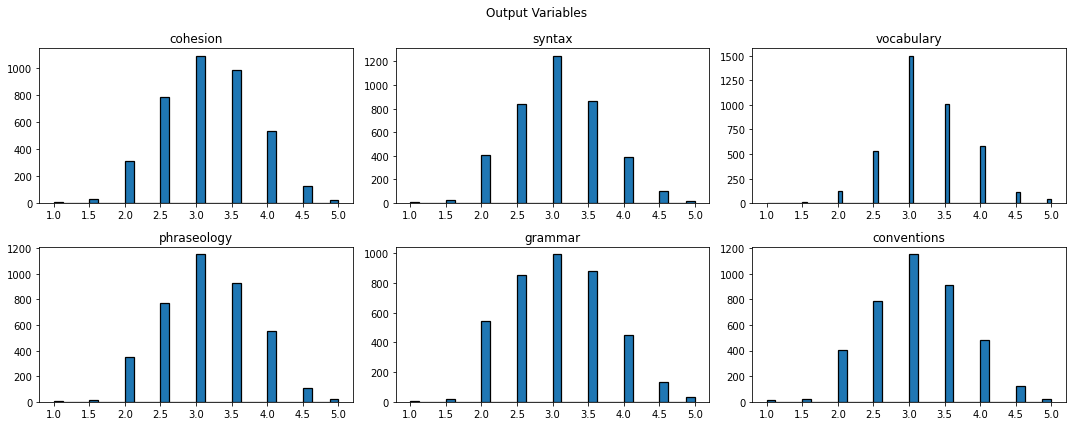

In [29]:
# target값을 리스트에 저장
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

# 각 target의 histplot을 그림
for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=df_train, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

### Correlations

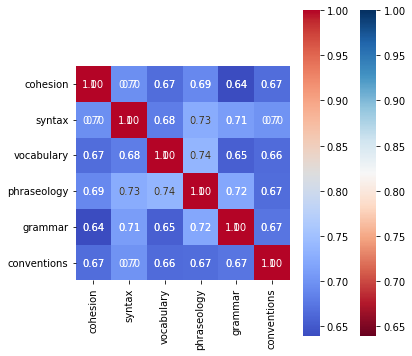

In [57]:
# 상관관계 분석
corr = df_train[targets].corr()
fig, ax = plt.subplots(figsize=(6,6))        
sns.heatmap(corr, cmap = "RdBu", square=True, annot=True, ax=ax)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


## Text Examples

In [59]:
def print_texts(df):
    inner_html = ""
    for idx, row in df.iterrows():
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.text_id}</h3>
        <hr>
            <dl>
                <dt>Cohesion Syntax Vocabulary Phraseology Grammar Conventions</dt>
                <dd>{row.cohesion} {row.syntax} {row.vocabulary} {row.phraseology} {row.grammar} {row.conventions}</dd>
            </dl>
            
            <hr>
            <p>
            {row.full_text[:500]}
            </p>
        </td>
        """
    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))

In [62]:
print_texts(df_train[0:2])

"0016926B079C Cohesion Syntax Vocabulary Phraseology Grammar Conventions 3.5 3.5 3.0 3.0 4.0 3.0 I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home. The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and",0022683E9EA5 Cohesion Syntax Vocabulary Phraseology Grammar Conventions 2.5 2.5 3.0 2.0 2.0 2.5 When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A problem is a change for you because it can make you see different and help you to understand how tings wok. First of all it can make you see different then the others. For example i remember that when i came to the United States i think


### Lowest Score Essays

In [32]:
# target 값 sum에서 제일 낮은 값 2개를 Lowest
df_train['total_score'] = df_train[targets].sum(axis=1)
lowest = df_train.sort_values('total_score').head(2)
print_texts(lowest)

767533E12569 Cohesion Syntax Vocabulary Phraseology Grammar Conventions 1.0 1.0 1.0 1.0 1.0 1.0 he is a good because they are the prescient and us. now the are more procession a other prescient and us. because and the more many education for student and school. the more school for one because he have a one women the have many education for a other because the good more the one is information for access because is not like the brazen giant of Greek fame with conquering one nation for is the imprison the eyes command the one book for people the us give more your lied your huddled Farmer with,48EA282A4EAF Cohesion Syntax Vocabulary Phraseology Grammar Conventions 1.0 1.0 1.0 1.0 1.0 1.0 some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. i think student would benefit form being able to attend classesfrom home. you are authorized take the electronic version of this you will taking this promptsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes from


### Highest Score Essays

In [33]:
# # target 값 sum에서 제일 높은 값 2개를 Highest
df_train['total_score'] = df_train[targets].sum(axis=1)
highest = df_train.sort_values('total_score', ascending=False).head(2)
print_texts(highest)

"B1AFACE6704E Cohesion Syntax Vocabulary Phraseology Grammar Conventions 5.0 5.0 5.0 5.0 5.0 5.0 I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride. Firstly, hard work is required to achieve high goals, and requires confidence. Confidence involves having tru","52DC3B7C3952 Cohesion Syntax Vocabulary Phraseology Grammar Conventions 5.0 5.0 4.5 5.0 5.0 5.0 Working From Home Should students be allowed to attend classes from home? I agree that attending classes while at home would be beneficial for many people and can actually help them work better. One reason is that it would be less stressful for the student and put a lot less pressure into getting the work done. Another reason is that it would give them more time to work, for example they could relax and take little breaks while working instead of having to cram all that work into one class sess"


## Text Analysis

### Number of Characters

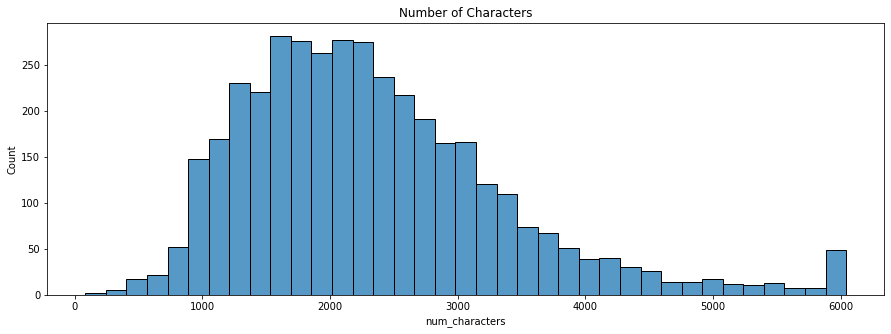

In [63]:
# num_characters column을 추가 -> 실제로 길게 쓴 text들의 평균 점수가 높은가?
fig = plt.figure(figsize=(15, 5))
df_train['num_characters'] = df_train['full_text'].str.len()
sns.histplot(data=df_train, x="num_characters")
plt.title("Number of Characters")
plt.show()

In [35]:
fig = px.histogram(df_train, x = df_train['full_text'].str.len(), marginal="box", 
                   title = "Number of Characters", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

### Number of Words

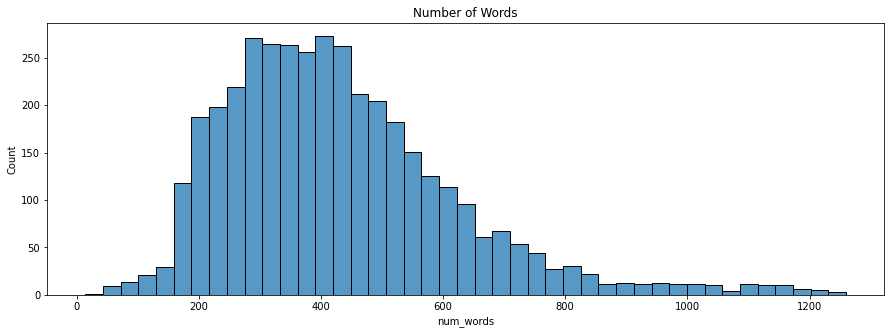

In [64]:
fig = plt.figure(figsize=(15, 5))
df_train['num_words'] = df_train['full_text'].apply(lambda x: len(x.split()))
#df_train['num_words'] = df_train['full_text'].str.split().map(lambda x: len(x))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

In [65]:
fig = px.histogram(df_train, x = df_train['num_words'], marginal="box", 
                   title = "Number of Words", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [66]:
df_train['num_words'].describe()

count    3911.000000
mean      430.492969
std       191.868449
min        14.000000
25%       294.000000
50%       402.000000
75%       526.500000
max      1260.000000
Name: num_words, dtype: float64

### Average Word Length

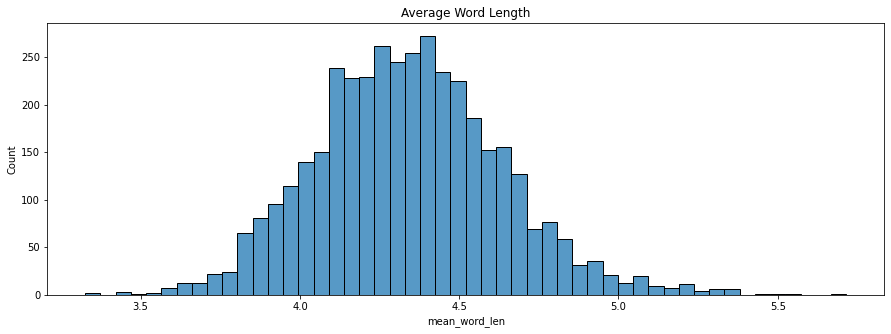

In [39]:
fig = plt.figure(figsize=(15, 5))
df_train['mean_word_len'] = df_train['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
sns.histplot(data=df_train, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

In [40]:
fig = px.histogram(df_train, x=df_train['mean_word_len'], marginal="box", 
                   title = "Average Word Length", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

### Common Stopwords

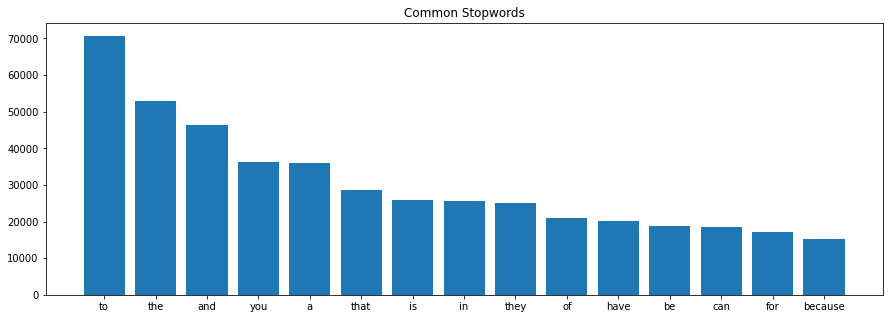

In [41]:
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words('english'))
corpus = ''.join(df_train.full_text).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15] 
x, y = zip(*top_words)
plt.bar(x, y)
plt.title('Common Stopwords')
plt.show()

### Common Words

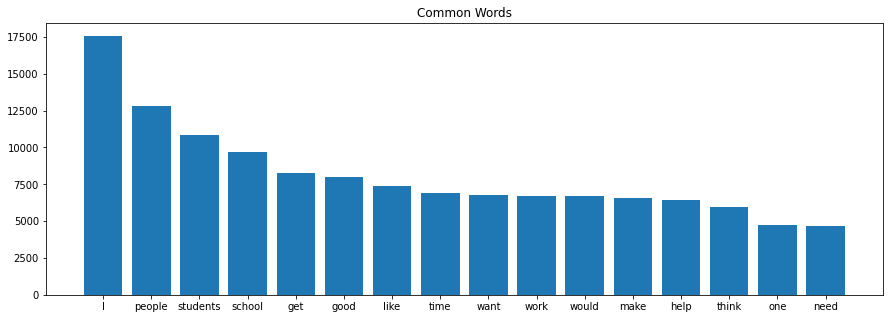

In [42]:
fig = plt.figure(figsize=(15, 5))

counter = Counter(corpus)
words = counter.most_common()

x, y = [], []
i = 0
for word, count in words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)  
        i += 1
    if i > 15:
        break
plt.bar(x, y)
plt.title('Common Words')
plt.show()

### Word Cloud

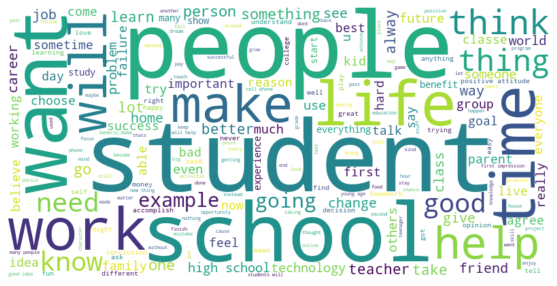

In [43]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### N-grams Analysis

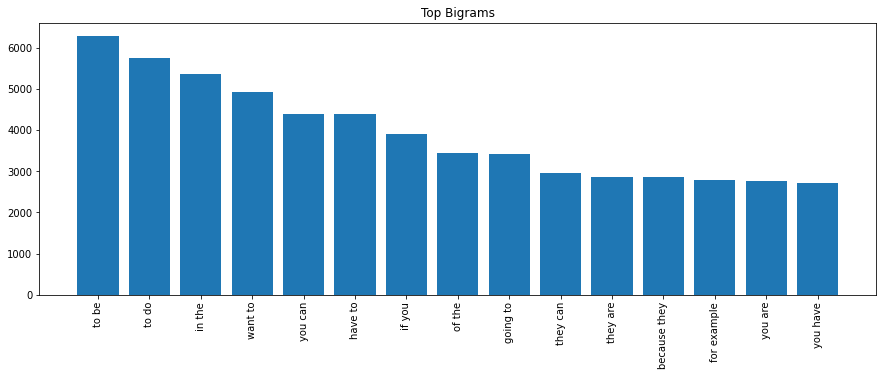

In [44]:
fig = plt.figure(figsize=(15, 5))

def get_top_bigrams(corpus, n):
    vectorizer = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

top_bigrams = get_top_bigrams(df_train['full_text'], n=2)[:15]
x, y = map(list, zip(*top_bigrams))
plt.bar(x, y)
plt.title('Top Bigrams')
plt.xticks(rotation=90)
plt.show()